In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
config = {
    "base_dir":        "/eos/home-j/jixiao/latino/",
    "plot_config":     "2018_WW",
    "cut":             "ssww_leppt1_jetpt30",
    "model_version":   "v5",
    "model_tag":       "res_5depth_l2reg_v2",
    "samples_version": "v5",
    "cols": ['mll',
             'Lepton_pt1',
             'Lepton_pt2',
             'Lepton_eta1',
             'Lepton_eta2',
             'detall',
             'Lepton_phi1',
             'Lepton_phi2',
             'dphill',  
             'Jet_pt1',
             'Jet_pt2',
             'Jet_eta1',
             'Jet_eta2',
             'detajj',
             'Jet_phi1',
             'Jet_phi2',
             'dphijj',
             'met',
             'zlep1',
             'Zlep2',
             ],
    "test_size": 0.2,
    "val_size":  0.0,
    "batch_size": 2048
}
len(config["cols"])

20

In [3]:
import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])

import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training_WW/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training_WW/background_balanced.pkl"), "rb"))

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


In [5]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight_"]).values
Wnn_bkg = (bkg["weight_"]).values

In [6]:
X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

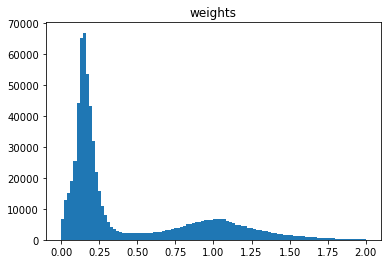

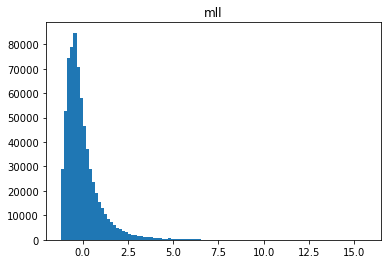

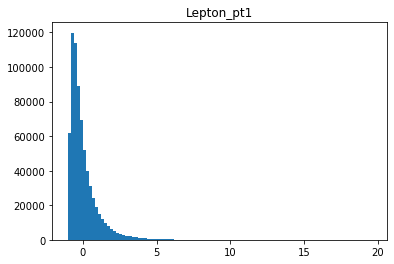

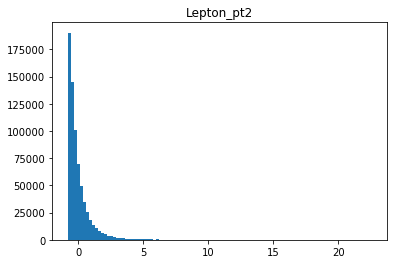

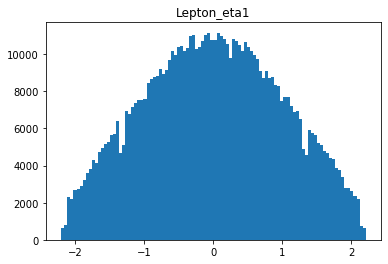

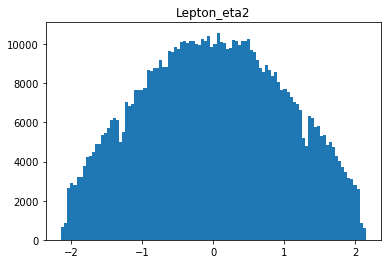

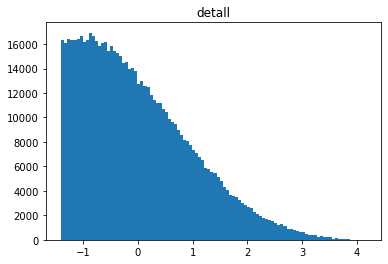

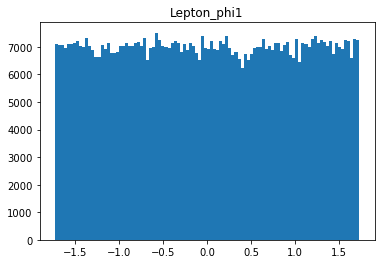

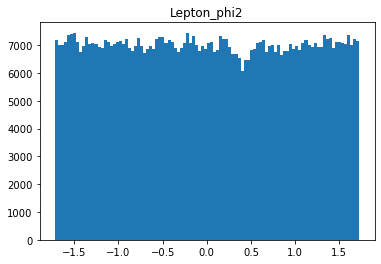

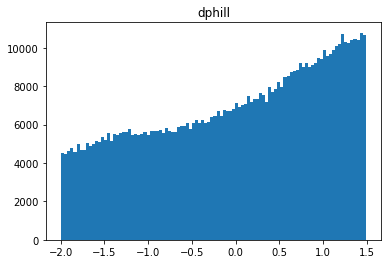

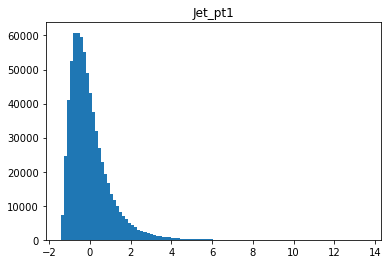

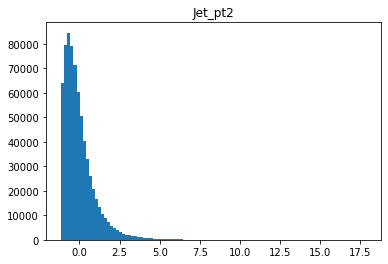

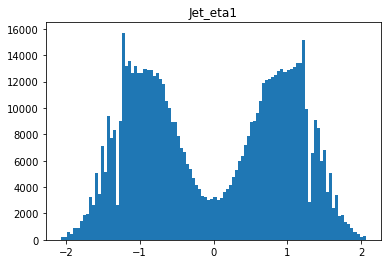

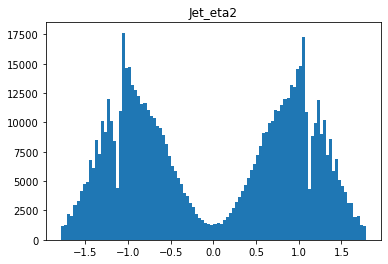

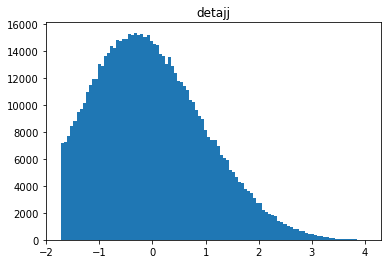

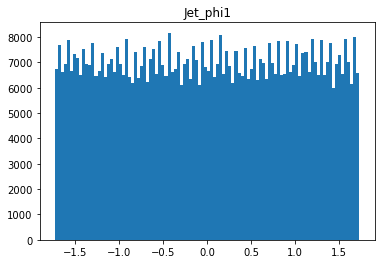

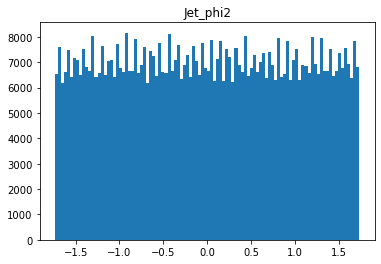

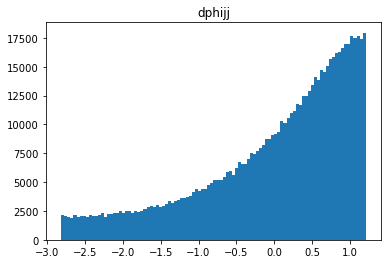

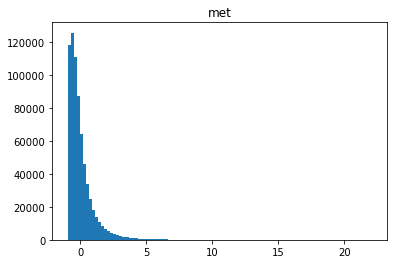

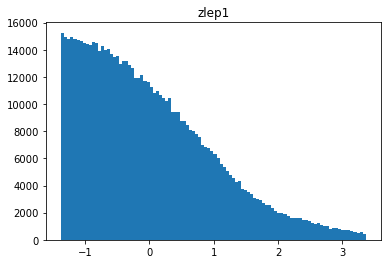

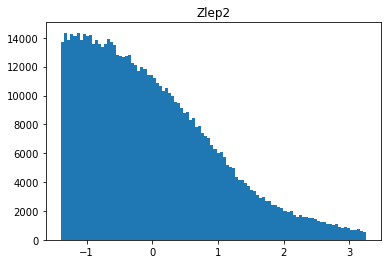

In [8]:
## draw weights and input variables in order to spot any importing error
_ = plt.hist(W, bins=100, range=(0,2))
plt.title("weights")
plt.show()
for idx,col in enumerate(config["cols"]):
    _ = plt.hist(X_scaled[:,idx], bins=100)
    plt.title(col)
    plt.show()

In [9]:
X_train, X_temp, y_train, y_temp, W_train, W_temp , Wnn_train, Wnn_temp = train_test_split(X_scaled, Y,  W, Wnn, test_size=config["test_size"], random_state=42, stratify=Y)

In [10]:
print("Training   dataset: ", X_train.shape)
print("Test + Val dataset: ", X_temp.shape)

Training   dataset:  (560328, 20)
Test + Val dataset:  (140082, 20)


In [11]:
training_generator,   steps_per_epoch_train = balanced_batch_generator(X_train, y_train, W_train, batch_size=config["batch_size"], sampler=RandomOverSampler())
#validation_generator, steps_per_epoch_val   = balanced_batch_generator(X_val,   y_val,   W_val,   batch_size=config["batch_size"], sampler=RandomOverSampler()) ## test != val
validation_generator, steps_per_epoch_val   = balanced_batch_generator(X_temp,  y_temp,  W_temp,   batch_size=config["batch_size"], sampler=RandomOverSampler()) ## test == val

In [12]:
%load_ext autoreload
%autoreload 2

In [13]:
# import local module that programmatically returns keras models
import dnn_models

print(config["model_tag"])
model = dnn_models.get_model(config["model_tag"], X_train.shape[1])

model.compile(optimizer="sgd",
            loss='binary_crossentropy',
            metrics=['accuracy'])

model.summary()

W0604 17:29:03.789474 140272338229056 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0604 17:29:03.829053 140272338229056 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0604 17:29:03.836266 140272338229056 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0604 17:29:03.879294 140272338229056 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x8

res_5depth_l2reg_v2
>>> Creating model...


W0604 17:29:04.211184 140272338229056 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0604 17:29:04.253292 140272338229056 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0604 17:29:04.262828 140272338229056 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                1050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
__________

In [14]:
## import and configure the plot loss callback

import dnn_plot_loss

data = {
    "X_train": X_train,
    #"X_test" : X_test, ## test != val
    "X_val" : X_temp, ## test == val
    "y_train": y_train,
    #"y_test" : y_test, ## test != val
    "y_val" : y_temp, ## test == val
    "W_train": W_train,
    #"W_test" : W_test, ## test != val
    "W_val": W_temp, ## test == val
    "Wnn_train": Wnn_train,

    #"W_test" : W_test, ## test != val
    "Wnn_val": Wnn_temp, ## test == val
}

plot_losses = dnn_plot_loss.PlotLosses(model, data, batch_mode=False)

In [15]:
import math
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.65
    epochs_drop = 4.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if lrate < 0.002: return 0.002
    return lrate

In [16]:
## TRAINING without random sampling

import time
start_time = time.time()
from keras import callbacks

early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                            min_delta=0.001, patience=20, verbose=0, mode='auto', 
                            baseline=None, restore_best_weights=True)

lr_scheduler = callbacks.LearningRateScheduler(step_decay, verbose=1)

config["epochs"] = 300

history = model.fit(
            X_train, y_train,
            sample_weight = W_train,
            epochs=config["epochs"],
            validation_data  = (X_temp, y_temp, W_temp),
            callbacks=[plot_losses, early_stopping,lr_scheduler], #lr_scheduler
            shuffle = True,
            batch_size= config["batch_size"]
            #callbacks = [], 
            )

config["train_time"] = time.time() - start_time

Train on 560328 samples, validate on 140082 samples
Epoch 1/300

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
560328/560328 [==============================] - 10s 18us/step - loss: 1.2125 - acc: 0.5086 - val_loss: 0.8493 - val_acc: 0.5309


ValueError: x is neither increasing nor decreasing : [0.00000000e+00 2.53659378e-06 2.53659378e-06 ... 9.99988840e-01
 9.99992026e-01 1.00000000e+00].

<Figure size 432x288 with 0 Axes>

In [ ]:
## TRAINING with generators and random sampling

#import time
#start_time = time.time()
#from keras import callbacks

#early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
#                            min_delta=0.001, patience=20, verbose=0, mode='auto', 
#                            baseline=None, restore_best_weights=True)

#lr_scheduler = callbacks.LearningRateScheduler(step_decay, verbose=1)

#config["epochs"] = 300

#history = model.fit_generator(
#            training_generator, 
#            epochs=config["epochs"],
#            steps_per_epoch  = steps_per_epoch_train, 
#            validation_data  = validation_generator, 
#            validation_steps = steps_per_epoch_val,
#            callbacks=[plot_losses, early_stopping, lr_scheduler],#
#            #callbacks = [], 
#            )

#config["train_time"] = time.time() - start_time

In [ ]:
## SAVE THE MODEL, ITS METADATA AND TRAINING INFORMATIONS

# dump the variables list
print(model_dir)
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

In [ ]:
## SAVE THE MODEL, ITS METADATA AND TRAINING INFORMATIONS

# dump the variables list
import yaml
varfile = os.path.join(model_dir, "variables.yml")
if os.path.isfile(varfile):
    print("ACHTUNG! variables file already existing: old file renamed with '_old'")
    os.rename(varfile, varfile[:-4] + "_old.yml")
with open(varfile, "w") as out_var_file:
    out_var_file.write(yaml.dump(config["cols"]))
    
# dump the config
config["a__model_dir"] = model_dir
model_config_file = os.path.join(model_dir, "model_config.yml")
if os.path.isfile(model_config_file):
    print("ACHTUNG! model_config_file file already existing: old file renamed with '_old'")
    os.rename(model_config_file, model_config_file[:-4] + "_old.yml")
with open(model_config_file, "w") as out_var_file:
    out_var_file.write(yaml.dump(config))  

# save figure with training summary
plot_losses.save_figure( os.path.join(model_dir, "model_train.png") )

# save keras model
model.save( os.path.join(model_dir, "model.h5") )

In [ ]:
## Export:
## * keras model to tensorflow model
## * tf metadata
## * scaler

args = {
    "dir": model_dir,
    "input": "model.h5",
    "output": "model.pb",
    "tf_metadata": "tf_metadata.txt",
    "input_scaler": "scaler_model.pkl",
    "output_scaler": "scaler.txt",
}


from keras import backend as K
# This line must be executed before loading Keras model.
K.set_learning_phase(0)

from keras.models import load_model
model = load_model(os.path.join(args["dir"], args["input"]))

from keras import backend as K
import tensorflow as tf


In [ ]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


In [ ]:
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

# Save to ./model/tf_model.pb
tf.train.write_graph(frozen_graph, args["dir"], args["output"], as_text=False)

## save tensorflow metadata
with open(os.path.join(args["dir"], args["tf_metadata"]), "w") as f:
    f.write(str(model.inputs[0].name) + " " + str(model.outputs[0].name) + "\n")


## Export 
## * tf tensor input name and output name
## * scaler mean_ and scale_ (where scale_ = np.sqrt(var_)) for each variable
##
import os
import pickle

import yaml
yaml_vars = yaml.safe_load(open(os.path.join(args["dir"], "variables.yml"), "r"))

scaler = pickle.load(open(os.path.join(args["dir"], args["input_scaler"]), 'rb'))
with open(os.path.join(args["dir"], args["output_scaler"]), "w") as f:
    for var, mean, scale in zip(yaml_vars, scaler.mean_, scaler.scale_):
        f.write(var + " " + str(mean) + " " + str(scale) + "\n")

In [ ]:
model_dir